# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Kwaku | Owusu | KO 25/10/2024 | 15 Hours | 33% |
| Member 2: | Tunde | Bademosi | TB 25/10/2024 | 15 Hours | 33% |
| Member 3: | Bukola | Sikiru | BS 25/10/2024 | 15 Hours | 33% |
| Member 4: |  |  |  |  |  |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

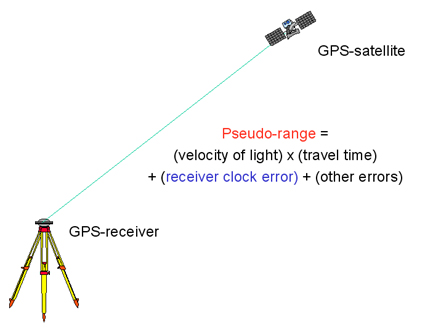

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/engg680_2024_fall/Lab Assignment 3

/content/drive/MyDrive/Colab Notebooks/engg680_2024_fall/Lab Assignment 3


In [ ]:
df_pseudorange = pd.read_excel('pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('satellite_position1.xlsx')

In [ ]:
pseudorange = df_pseudorange['P'].to_numpy()
s_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size
print(n)
print(s_pos)
print(pseudorange)

11
[[  5280791.73836563 -25501460.1192133    4649508.28809917]
 [ -2159656.05205653 -21116024.7920163   15597909.1971221 ]
 [ 10371852.1682927  -21713111.3497771   10558686.998121  ]
 [-16085760.7811889    4285071.21612309  20742042.1246963 ]
 [-14312988.0806279  -22045014.2659254    4671208.3988653 ]
 [ -2435718.18737303  16257205.12951     21099779.5379103 ]
 [ 15912467.1868696   -3462515.31492602  21053628.253335  ]
 [ 16271848.163885     -218766.32031082  21035332.7037679 ]
 [-19247035.5286677   -7259803.67892242  16472981.9071979 ]
 [-15931152.0364578   12077367.2515846   18058076.7648504 ]
 [ -7680014.10843999 -13855462.7231353   21842975.3728112 ]]
[22919740.9614295 20459894.0877988 22400338.4134134 22829140.9126004
 22342014.8171753 25646454.5362932 23814776.2454228 24311399.3171521
 21353640.1406793 24971609.6374347 20638981.0590005]


Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [ ]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [ ]:
arr_cost= []          # Store cost values during optimization
arr_grad= []          # Hold gradient values
arr_err= []           # Track of errors during iterations
steps_count=0         # Counts number of iterations

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [ ]:
def euclidean_norm(r_pos, s_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(s_pos - r_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [ ]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
  """
  Compute the sum of squared residuals between measured and predicted pseudoranges.

  Parameters:
  r_pos (numpy array):        A 1D array of the receiver's coordinates [x, y, z].
  cdT (float):                The clock offset of the receiver.
  s_pos (numpy array):        A 2D array where each row represents a satellite's coordinates [x, y, z].
  pseudorange (numpy array):  A 1D array of observed pseudoranges (distance measurements).

  Returns:
  float: The sum of squared residuals between the observed and predicted pseudoranges.
  """
  # Calculate the geometric distances using the euclidean_norm function
  predicted_distances = euclidean_norm(r_pos, s_pos)

  # Calculate the predicted pseudoranges by adding the clock offset
  predicted_pseudoranges = predicted_distances + cdT

  # Calculate residuals (differences between observed and predicted pseudoranges)
  residuals = pseudorange - predicted_pseudoranges

  # Compute the sum of squared residuals
  cost = np.sum(residuals ** 2)

  return cost


### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [ ]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):
    """
    Compute the gradient of the cost function with respect to the receiver's coordinates
    (x_r, y_r, z_r) and clock offset (cdT).

    Parameters:
    r_pos (numpy array):       A 1D array of the receiver's coordinates [x_r, y_r, z_r].
    cdT (float):               The clock offset (cdT) of the receiver.
    s_pos (numpy array):       A 2D array where each row represents a satellite's coordinates [x, y, z].
    pseudorange (numpy array): A 1D array of observed pseudoranges.

    Returns:
    numpy array: A 1D array containing the gradient [∂C/∂x_r, ∂C/∂y_r, ∂C/∂z_r, ∂C/∂cdT].
    """
    # Calculate the predicted distances (geometric distance) from receiver to each satellite
    predicted_distances = euclidean_norm(r_pos, s_pos)

    # Predicted pseudoranges, which include the clock offset
    predicted_pseudoranges = predicted_distances + cdT

    # Calculate residuals
    residuals = pseudorange - predicted_pseudoranges

    # Compute the partial derivatives with respect to each coordinate and clock offset
    # Initialize gradient array
    grad = np.zeros(4)

    # Partial derivatives with respect to x_r, y_r, z_r
    for i in range(3):  # Loop over x, y, z
        grad[i] = -2 * np.sum(residuals * (r_pos[i] - s_pos[:, i]) / predicted_distances)

    # Partial derivative with respect to clock offset (cdT)
    grad[3] = -2 * np.sum(residuals)

    return grad


### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [ ]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.01, max_iters=50000, tolerance=1e-5):


    # Initialize arr_cost, arr_grad, and arr_err as empty lists
    global arr_cost, arr_grad, arr_err, steps_count
    arr_cost = []
    arr_grad = []
    arr_err = []


    #initalize the estimates as zeros
    X = np.array([0.0,0.0,0.0,0.0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)

        # Clip gradients to avoid excessively large updates
        grad = np.clip(grad, -1e10, 1e10)


        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)


        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration

            break

        # update the parameters for the next iteration
        X = X_new



    # Handle empty arr_cost before accessing last element
    if arr_cost:  # Check if arr_cost is not empty
        final_cost = arr_cost[-1]
    else:
        final_cost = float('nan')  # Assign NaN if arr_cost is empty
    # Handle empty arr_grad before accessing last element
    if arr_grad:  # Check if arr_grad is not empty
        final_grad = arr_grad[-1]
    else:
        final_grad = float('nan')  # Assign NaN if arr_grad is empty

    return X, final_cost, final_grad


### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [ ]:

# Call the gradient_descent function to optimize
optimized_params, final_cost, final_grad = gradient_descent(pseudorange, s_pos, learning_rate=0.01, max_iters=50000, tolerance=1e-5)

# Calculate final position errors (GroundTruth defined previously)
final_position_error = optimized_params[:3] - GroundTruth # optimized_params is now a NumPy array with the optimized parameters

# print the mentioned metrics
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params)
print("Final Position Errors of Receiver:", final_position_error)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost)        # Use final_cost returned by gradient_descent
print("Final Gradient Values:", final_grad)   # Use final_grad returned by gradient_descent

Converged !
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162953e+06  4.95248539e+06  6.45062254e+00]
Final Position Errors of Receiver: [-3.06263628 -2.34759892  3.77542716]
Number of Steps Taken for Convergence: 2707
Final Cost Value: 6.197732806237501
Final Gradient Values: [ 0.00153783  0.00856877 -0.02633535 -0.0149302 ]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

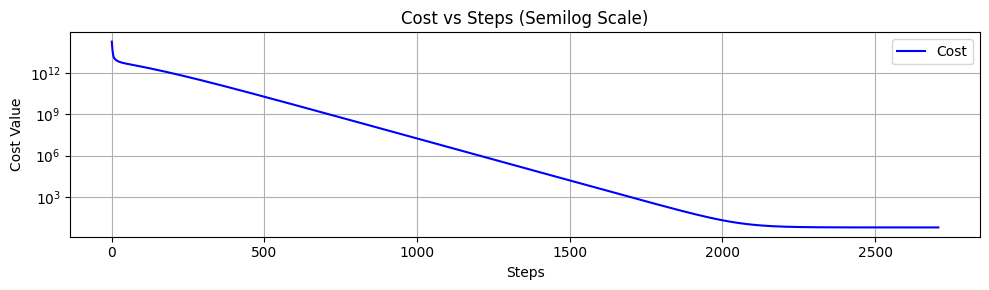

In [ ]:

# Generate steps array
steps = np.arange(steps_count + 1)  # steps_count + 1 to include the final step

# Initialize figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

# Plot cost vs steps with semilog scale
ax.semilogy(steps, arr_cost, label='Cost', color='blue')

# Label the axes
ax.set_xlabel("Steps")
ax.set_ylabel("Cost Value")
ax.set_title("Cost vs Steps (Semilog Scale)")

# Add grid and legend
ax.grid(True)
ax.legend()

# Optimize layout
fig.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Comment on the pattern
# this graph demonstrates a typical convergence pattern, with an initial rapid reduction in cost followed by a slower approach to the minimum. The semilog scale effectively shows how the cost transitions from large to very small values, reflecting successful optimization

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

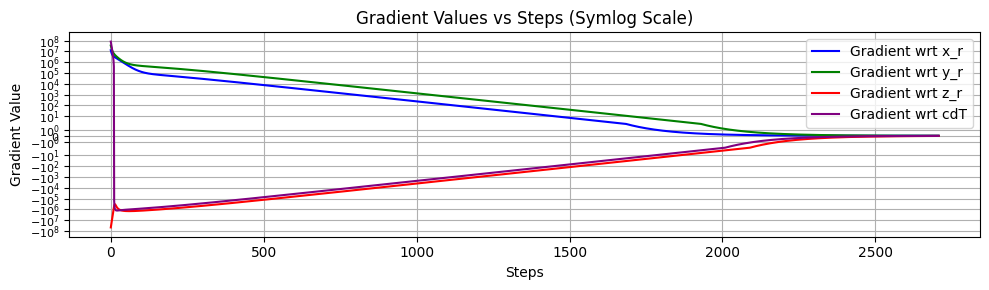

In [ ]:
# Initialize figure and axes
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
# Convert arr_grad to a numpy array for easier plotting
arr_grad = np.array(arr_grad)

# Extract gradient components and steps
grad_x, grad_y, grad_z, grad_cdT = arr_grad[:, 0], arr_grad[:, 1], arr_grad[:, 2], arr_grad[:, 3]
steps = np.arange(len(arr_grad))

# Plot each gradient component
ax.plot(steps, grad_x, label='Gradient wrt x_r', color='b')
ax.plot(steps, grad_y, label='Gradient wrt y_r', color='g')
ax.plot(steps, grad_z, label='Gradient wrt z_r', color='r')
ax.plot(steps, grad_cdT, label='Gradient wrt cdT', color='purple')

# Set y-axis to symlog scale
ax.set_yscale('symlog')

# Customize y-axis tick labels
ax.tick_params(axis='y', labelsize=8)

# Add labels, title, legend, and grid
ax.set_xlabel("Steps")
ax.set_ylabel("Gradient Value")
ax.set_title("Gradient Values vs Steps (Symlog Scale)")
ax.legend()
ax.grid(True)  # Add gridlines

# Adjust layout for better spacing
fig.tight_layout()

# Show the plot
plt.show()



In [ ]:
# Comment on the pattern
# this graph suggest that the optimization is largely successful, with most variables stabilizing over time.
# However, the parameter 𝑐⋅𝑑𝑇 may require special attention, as it exhibits a different trend and may influence the final stability or accuracy of the model.

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

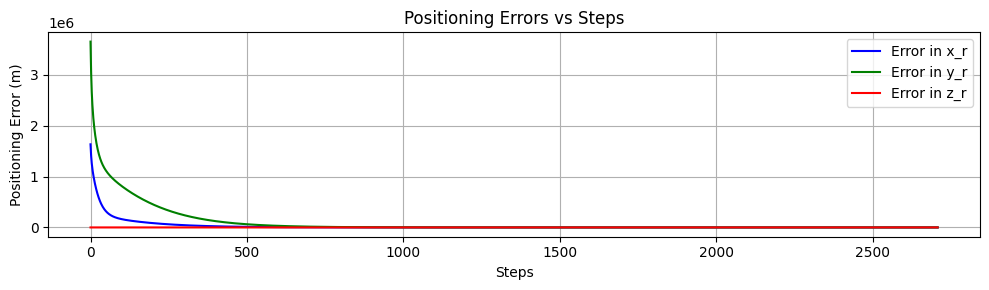

In [ ]:
# Convert arr_err to a numpy array for easier plotting
arr_err = np.array(arr_err)

# Filter out NaN and Inf values
arr_err = np.nan_to_num(arr_err, nan=np.inf, posinf=np.inf)

# Clip large cost values to prevent overflow in plotting
max_err_value = 1e10  # Define a suitable max value based on your data
arr_err = np.clip(arr_err, 0, max_err_value)


# Create an array for steps
steps = np.arange(len(arr_err))

# Initialize figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

# Plot positioning errors vs steps
# Extracting the x, y, and z positioning errors
ax.plot(steps, arr_err[:, 0], label='Error in x_r', color='blue')
ax.plot(steps, arr_err[:, 1], label='Error in y_r', color='green')
ax.plot(steps, arr_err[:, 2], label='Error in z_r', color='red')

# Label the axes
ax.set_xlabel("Steps")
ax.set_ylabel("Positioning Error (m)")
ax.set_title("Positioning Errors vs Steps")

# Add grid, legend
ax.grid(True)
ax.legend()

# Optimize layout
fig.tight_layout()

# Show the plot
plt.show()



In [ ]:
# Comment on the pattern
# The pattern shows that the system corrects initial errors effectively, achieving high positional accuracy and stability as the steps increase.


# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [ ]:
# Setting learning rate to 0.1
# re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

In [ ]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.1, max_iters=50000, tolerance=1e-5):


    # Initialize arr_cost, arr_grad, and arr_err as empty lists
    global arr_cost, arr_grad, arr_err, steps_count
    arr_cost = []
    arr_grad = []
    arr_err = []


    #initalize the estimates as zeros
    X = np.array([0.0,0.0,0.0,0.0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)

        # Clip gradients to avoid excessively large updates
        grad = np.clip(grad, -1e10, 1e10)


        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)


        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration

            break

        # update the parameters for the next iteration
        X = X_new



    # Handle empty arr_cost before accessing last element
    if arr_cost:  # Check if arr_cost is not empty
        final_cost = arr_cost[-1]
    else:
        final_cost = float('nan')  # Assign NaN if arr_cost is empty
    # Handle empty arr_grad before accessing last element
    if arr_grad:  # Check if arr_grad is not empty
        final_grad = arr_grad[-1]
    else:
        final_grad = float('nan')  # Assign NaN if arr_grad is empty

    return X, final_cost, final_grad


In [ ]:
optimized_params_2 = gradient_descent(pseudorange, s_pos, learning_rate = 0.1)


# print the metrics
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params)
print("Final Position Errors of Receiver:", final_position_error)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost)        # Use final_cost returned by gradient_descent
print("Final Gradient Values:", final_grad)   # Use final_grad returned by gradient_descent

Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162953e+06  4.95248539e+06  6.45062254e+00]
Final Position Errors of Receiver: [-3.06263628 -2.34759892  3.77542716]
Number of Steps Taken for Convergence: 2707
Final Cost Value: 8.127807518434048e+18
Final Gradient Values: [-1.e+10  1.e+10  1.e+10 -1.e+10]


In [ ]:
# Setting learning rate to 0.001
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0


In [ ]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.001, max_iters=50000, tolerance=1e-5):


    # Initialize arr_cost, arr_grad, and arr_err as empty lists
    global arr_cost, arr_grad, arr_err, steps_count
    arr_cost = []
    arr_grad = []
    arr_err = []


    #initalize the estimates as zeros
    X = np.array([0.0,0.0,0.0,0.0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)

        # Clip gradients to avoid excessively large updates
        grad = np.clip(grad, -1e10, 1e10)


        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)


        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration

            break

        # update the parameters for the next iteration
        X = X_new



    # Handle empty arr_cost before accessing last element
    if arr_cost:  # Check if arr_cost is not empty
        final_cost = arr_cost[-1]
    else:
        final_cost = float('nan')  # Assign NaN if arr_cost is empty
    # Handle empty arr_grad before accessing last element
    if arr_grad:  # Check if arr_grad is not empty
        final_grad = arr_grad[-1]
    else:
        final_grad = float('nan')  # Assign NaN if arr_grad is empty

    return X, final_cost, final_grad


In [ ]:
optimized_params_3 = gradient_descent(pseudorange, s_pos, learning_rate = 0.001)


# print the metrics
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params)
print("Final Position Errors of Receiver:", final_position_error)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost)        # Use final_cost returned by gradient_descent
print("Final Gradient Values:", final_grad)   # Use final_grad returned by gradient_descent

Converged !
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162953e+06  4.95248539e+06  6.45062254e+00]
Final Position Errors of Receiver: [-3.06263628 -2.34759892  3.77542716]
Number of Steps Taken for Convergence: 25500
Final Cost Value: 6.197732806237501
Final Gradient Values: [ 0.00153783  0.00856877 -0.02633535 -0.0149302 ]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

Q1. Initially running the Optimized parameter with learning_rate=0.01, max_iters=100000, tolerance=1e-6, it couldnt converged,the Number of Steps was zero and the graph didnt show any plot lines. Then have to adjust the parameters to learning_rate=0.01, max_iters=50000, tolerance=1e-5. Then it converged and it show plotline in the graph.

Changing to learning_rate=0.1, max_iters=50000, tolerance=1e-5, it didnt converged,Number of Steps was 2707 and Final Cost Value = 8.12780e18.

Further changing parameters to learning_rate=0.001, max_iters=50000, tolerance=1e-5, it converged, Number of Steps was 25500 and Final Cost Value = 6.1877

Q2. LSE uses an analytical solution, where a closed-form formula is derived directly to calculate the optimal parameters, which relies on matrix operations and is computationally efficient. LSE usually assumes a linear relationship between the independent and dependent variables, and the errors are normally distributed.
While Gradient descent is an iterative optimization algorithm that begins with an initial guess for the parameters and subsequently updates them by moving in the direction of the negative gradient of the cost function. This process continues until convergence at a minimum is achieved.


---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# Access the data and convert it to a pandas DataFrame
phishing_websites_df = pd.DataFrame(phishing_websites.data.features, columns=phishing_websites.data.feature_names)

# Now you can use head() on the DataFrame
print(phishing_websites_df.head())

   having_ip_address  url_length  shortining_service  having_at_symbol  \
0                 -1           1                   1                 1   
1                  1           1                   1                 1   
2                  1           0                   1                 1   
3                  1           0                   1                 1   
4                  1           0                  -1                 1   

   double_slash_redirecting  prefix_suffix  having_sub_domain  sslfinal_state  \
0                        -1             -1                 -1              -1   
1                         1             -1                  0               1   
2                         1             -1                 -1              -1   
3                         1             -1                 -1              -1   
4                         1             -1                  1               1   

   domain_registration_length  favicon  ...  rightclick  popupwindow

In [ ]:
X = phishing_websites_df  # All feature columns are already present in phishing_websites_df
y = phishing_websites.data.targets['result']  # Access the target column from the original dataset object


In [ ]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)

# Check if phishing_websites.data is a pandas DataFrame
if isinstance(phishing_websites.data, pd.DataFrame):
    # If it's already a DataFrame, use it directly
    X = phishing_websites.data.drop(columns=['result'])
    y = phishing_websites.data['result']
else:
    # If it's not a DataFrame, convert it to one
    # Assuming phishing_websites.data.features and phishing_websites.data.feature_names are available
    X = pd.DataFrame(phishing_websites.data.features, columns=phishing_websites.data.feature_names)
    # The 'result' column is in the targets, not features
    y = pd.Series(phishing_websites.data.targets['result'])


# TO DO: display sizes of X and y (1 mark)
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (11055, 30)
Shape of y: (11055,)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

result
 1    6157
-1    4898
Name: count, dtype: int64


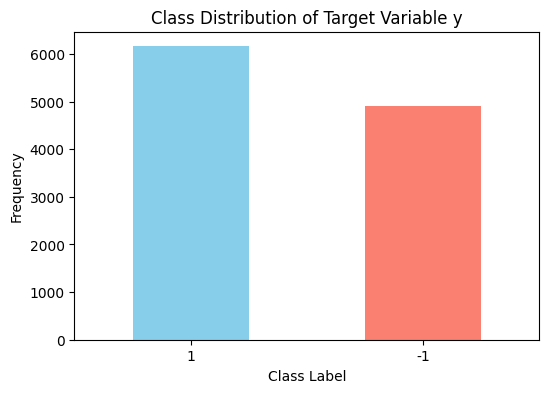

In [ ]:
# TO DO: Check the class distribution of y (2 mark)
class_distribution = y.value_counts()

# Display exact values for each bin in the histogram
print(class_distribution)

# Plotting the histogram for each class label in y
plt.figure(figsize=(6, 4))
y.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Class Distribution of Target Variable y")
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()


### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [ ]:
# TO DO: Create a smaller dataset with 3% of the data

from sklearn.model_selection import train_test_split

# Adjust to use your actual X and y variables for data splitting
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.97, random_state=42)


# TO DO: display sizes of X_small and y_small (2 mark)

# Display the sizes of X_small and y_small to confirm the split
print("X_small shape:", X_small.shape)
print("y_small shape:", y_small.shape)


X_small shape: (331, 30)
y_small shape: (331,)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Instantiate the LogisticRegression model with max_iter=2000
model = LogisticRegression(max_iter=2000)

# 1. Fit the model with the complete dataset X and y
model.fit(X, y)
print("Model trained on full dataset (X, y)")

# 2. Fit the model with only the first two columns of X and y
X_two_columns = X.iloc[:, :2]
model.fit(X_two_columns, y)
print("Model trained on first two columns of X and y")

# 3. Fit the model with X_small and y_small (previously created 3% sample of data)
model.fit(X_small, y_small)
print("Model trained on smaller dataset (X_small, y_small)")


Model trained on full dataset (X, y)
Model trained on first two columns of X and y
Model trained on smaller dataset (X_small, y_small)


### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss


# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=2000)

# Define a helper function to calculate and print results
def evaluate_model(X_data, y_data, description):
    # Split the data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

    # Fit the model on the training set
    model.fit(X_train, y_train)

    # Predictions and probabilities for the test set
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)

    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    log_loss_value = log_loss(y_test, y_test_proba)

    # Print results
    print(f"\nResults for {description}:")
    print("Data Size:", X_data.shape[0])
    print("Training Samples:", X_train.shape[0])
    print("Testing Samples:", X_test.shape[0])
    print("Training Accuracy:", train_accuracy)
    print("Testing Accuracy:", test_accuracy)
    print("Log Loss:", log_loss_value)

# 1. Full dataset (X, y)
evaluate_model(X, y, "Full dataset (X, y)")

# 2. First two columns of X and y
X_two_columns = X.iloc[:, :2]
evaluate_model(X_two_columns, y, "First two columns of X and y")

# 3. Smaller dataset (X_small, y_small)
evaluate_model(X_small, y_small, "Smaller dataset (X_small, y_small)")



Results for Full dataset (X, y):
Data Size: 11055
Training Samples: 8844
Testing Samples: 2211
Training Accuracy: 0.9300090456806874
Testing Accuracy: 0.924468566259611
Log Loss: 0.1884425737789789

Results for First two columns of X and y:
Data Size: 11055
Training Samples: 8844
Testing Samples: 2211
Training Accuracy: 0.5576662143826323
Testing Accuracy: 0.574400723654455
Log Loss: 0.6774413744952312

Results for Smaller dataset (X_small, y_small):
Data Size: 331
Training Samples: 264
Testing Samples: 67
Training Accuracy: 0.9621212121212122
Testing Accuracy: 0.8805970149253731
Log Loss: 0.24442993107860278


### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [ ]:

# Initialize the Logistic Regression model with max_iter=2000
model = LogisticRegression(max_iter=2000, random_state=0)

# Create an empty DataFrame to store results
results = pd.DataFrame(columns=[
    "Data size", "Training samples", "Testing samples",
    "Training accuracy", "Testing accuracy", "Log loss"
])

# Define a helper function to calculate and store results
def evaluate_model(X_data, y_data, description):
    # Split the data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.2, random_state=0
    )

    # Fit the model on the training set
    model.fit(X_train, y_train)

    # Predictions and probabilities for the test set
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)

    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    log_loss_value = log_loss(y_test, y_test_proba)

    # Append results to the DataFrame
    results.loc[description] = [
        X_data.shape[0],
        X_train.shape[0],
        X_test.shape[0],
        train_accuracy,
        test_accuracy,
        log_loss_value
    ]

# 1. Full dataset (X, y)
evaluate_model(X, y, "Full dataset (X, y)")

# 2. First two columns of X and y
X_two_columns = X.iloc[:, :2]
evaluate_model(X_two_columns, y, "First two columns of X and y")

# 3. Smaller dataset (X_small, y_small)
evaluate_model(X_small, y_small, "Smaller dataset (X_small, y_small)")

# Display the results DataFrame
print(results)


                                    Data size  Training samples  \
Full dataset (X, y)                   11055.0            8844.0   
First two columns of X and y          11055.0            8844.0   
Smaller dataset (X_small, y_small)      331.0             264.0   

                                    Testing samples  Training accuracy  \
Full dataset (X, y)                          2211.0           0.931818   
First two columns of X and y                 2211.0           0.563433   
Smaller dataset (X_small, y_small)             67.0           0.943182   

                                    Testing accuracy  Log loss  
Full dataset (X, y)                         0.917232  0.197934  
First two columns of X and y                0.551334  0.686008  
Smaller dataset (X_small, y_small)          0.910448  0.185828  


In [ ]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information



### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [ ]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set

from sklearn.metrics import confusion_matrix, classification_report

# Split the data into training and testing sets using the full dataset (X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train the model on the full dataset
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Print dimensions of the predicted output
print("Dimensions of the predicted output:", y_pred.shape)



Dimensions of the predicted output: (2211,)


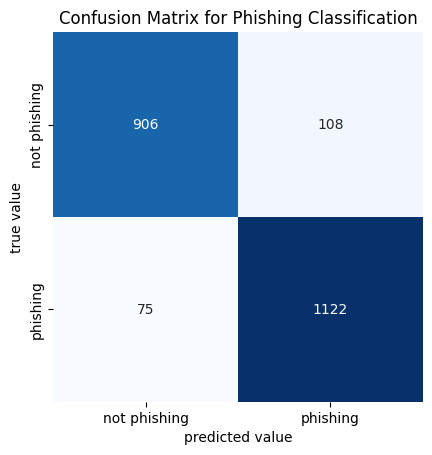

In [ ]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat
conf_mat = confusion_matrix(y_test, y_pred)

# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d', cmap='Blues')
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.title('Confusion Matrix for Phishing Classification')
plt.show()

In [ ]:
# TO DO: Print classification report (2 marks)

print(classification_report(y_test, y_pred, target_names=['not phishing', 'phishing']))

              precision    recall  f1-score   support

not phishing       0.92      0.89      0.91      1014
    phishing       0.91      0.94      0.92      1197

    accuracy                           0.92      2211
   macro avg       0.92      0.92      0.92      2211
weighted avg       0.92      0.92      0.92      2211





```
# This is formatted as code
```

ANSWER ** **bold text**HERE**

### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---1. Dataset is not imbalanced, and it doesn't affect model performance

---2. The model overfit for Full dataset (X, y), and Smaller dataset (X_small, y_small) and underfit for First two columns of X and y

---3. The training and testing accuracy changes as the amount of data used changes from 0.931818 - 0.563433 - 0.943182 for Training accuracy and from 0.917232 - 0.551334 - 0.910448 for Testing accuracy

---4. False Positive: Predicts a“phishing” site when it’s not.
False Negative: Predicts a “not phishing” site when it actually is.
False Negatives is worse because missing a phishing site as not could expose users to security risks, potentially compromising personal data.

---5. I would want to maximize recall because that will ensures that the model identifies most phishing sites, even if it results in some false positives, by adjusting the decision threshold or by oversampling the minority class to address class imbalance.

---6. The log loss for the full dataset should be lower to when the data is reduced, to reflect better performance and calibration. In this instance the  log loss is almost same even when dataset is reduced, which could mean that the model's probability estimate does not truelly match the class label.

